In [1]:
import os

import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### GATConv
Graph attention layer from Graph Attention Network
$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and
node $j$:

$$
\begin{align}\begin{aligned}\alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})\\e_{ij}^{l} &= 
\mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)\end{aligned}\end{align}
$$

这里的 $softmax_i$ 是对节点$i$的多个边进行归一化，不考虑其他边

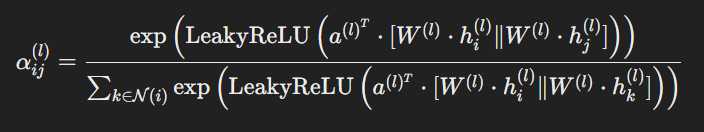

### 定义图

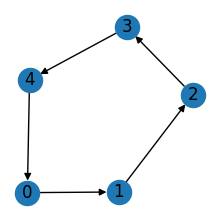

In [88]:
g = dgl.graph(([0, 1, 2, 3, 4], [1, 2, 3, 4, 0]))
# g=dgl.add_reverse_edges(g)
g.ndata["h"] = torch.FloatTensor(
    [
        [0, 0, 0, 0],  # 0
        [1, 1, 1, 1],  # 1
        [2, 2, 2, 2],  # 2
        [3, 3, 3, 3],  # 3
        [4, 4, 4, 4],  # 4
    ]
)
# g.edata["edge_weight"] = torch.FloatTensor([1,2,3,4,5])
# g.edata["edge_weight"] = torch.FloatTensor([1,2,3,4,5,6,7,8,9,10])


plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)


In [ ]:
from dgl.ops import edge_softmax

[W写在msg_func里](#W写在msg_func里) <br>
先求出边信息alpha/e，再直接用u_mul_e + sum 两个自带的函数来update

[W写在msg_func外](#W写在msg_func外)<br>
自定义了msg_fuc，在消息传递函数里乘W和边信息e

前者要更高效


### W写在msg_func外

In [113]:
W = torch.ones(4, 3)
a = torch.ones(6, 1)


def edge_attention(edges):
    hi = edges.dst["h"]
    hj = edges.src["h"]
    hiW = hi @ W
    hjW = hj @ W
    h_cat = torch.cat([hiW, hjW], dim=1)
    e = F.leaky_relu(h_cat @ a).squeeze()
    alpha=F.softmax(e,dim=-1)
    return {"alpha": alpha}


with g.local_scope():
    g.apply_edges(edge_attention)
    hW = g.ndata["h"] @ W
    # print(hW)
    g.ndata["hW"] = hW
    g.update_all(fn.u_mul_e("hW", "alpha", "hWe"), fn.sum("hWe", "h_N"))
    h_N = g.dstdata["h_N"]
    print(h_N)

tensor([[3.7112e-15, 3.7112e-15, 3.7112e-15],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7007e-21, 5.7007e-21, 5.7007e-21],
        [3.0201e-10, 3.0201e-10, 3.0201e-10],
        [1.2000e+01, 1.2000e+01, 1.2000e+01]])


### W写在msg_func里

In [119]:
W=torch.ones(4,3)
a=torch.ones(6,1)

def edge_attention(edges):
    hi = edges.dst["h"]
    hj = edges.src["h"]
    hiW = hi @ W
    hjW = hj @ W
    h_cat = torch.cat([hiW, hjW], dim=1)
    e = F.leaky_relu(h_cat @ a)
    alpha=F.softmax(e,dim=0)
    return {"alpha": alpha}
    
def msg_func(edges):
    alpha=edges.data['alpha']
    ehW=alpha*edges.src['h']@W
    return {'ehW':ehW}

def rdc_func(nodes):
    ehW=nodes.mailbox['ehW']
    return {'hN':ehW.sum(dim=1)}
    


with g.local_scope():
    g.apply_edges(edge_attention)
    g.update_all(msg_func,rdc_func)
    print(g.dstdata['hN'])

tensor([[3.7112e-15, 3.7112e-15, 3.7112e-15],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.7007e-21, 5.7007e-21, 5.7007e-21],
        [3.0201e-10, 3.0201e-10, 3.0201e-10],
        [1.2000e+01, 1.2000e+01, 1.2000e+01]])


In [ ]:
# tensor([[3.7112e-15, 3.7112e-15, 3.7112e-15],
#         [0.0000e+00, 0.0000e+00, 0.0000e+00],
#         [5.7007e-21, 5.7007e-21, 5.7007e-21],
#         [3.0201e-10, 3.0201e-10, 3.0201e-10],
#         [1.2000e+01, 1.2000e+01, 1.2000e+01]])

In [81]:
from dgl.nn import GATConv

In [122]:
g = dgl.graph(([0, 1, 2, 3, 4], [1, 2, 3, 4, 0]))
# g=dgl.add_reverse_edges(g)
g.ndata["h"] = torch.FloatTensor(
    [
        [0, 0, 0, 0],  # 0
        [1, 1, 1, 1],  # 1
        [2, 2, 2, 2],  # 2
        [3, 3, 3, 3],  # 3
        [4, 4, 4, 4],  # 4
    ]
)

In [140]:
gat_conv=GATConv(4,3,1)

torch.nn.init.ones_(gat_conv.fc.weight)
torch.nn.init.ones_(gat_conv.attn_l)
torch.nn.init.ones_(gat_conv.attn_r)

print(gat_conv.fc.weight)
print(gat_conv.attn_l)
print(gat_conv.attn_r)


Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)


In [148]:

gat_conv(g,g.ndata['h'],get_attention=True)


(tensor([[[16., 16., 16.]],
 
         [[ 0.,  0.,  0.]],
 
         [[ 4.,  4.,  4.]],
 
         [[ 8.,  8.,  8.]],
 
         [[12., 12., 12.]]], grad_fn=<AddBackward0>),
 tensor([[[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]]], grad_fn=<EdgeSoftmaxBackward>))